# Clustering embeddings to help GPT extract high-level insights

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
import openai
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from sklearn.cluster import KMeans
from IPython.display import display, Markdown, Latex
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pickle

# Generate embeddings

<br>

Let's use the OpenAI API to generate embeddings for us.

<br>

<div>
    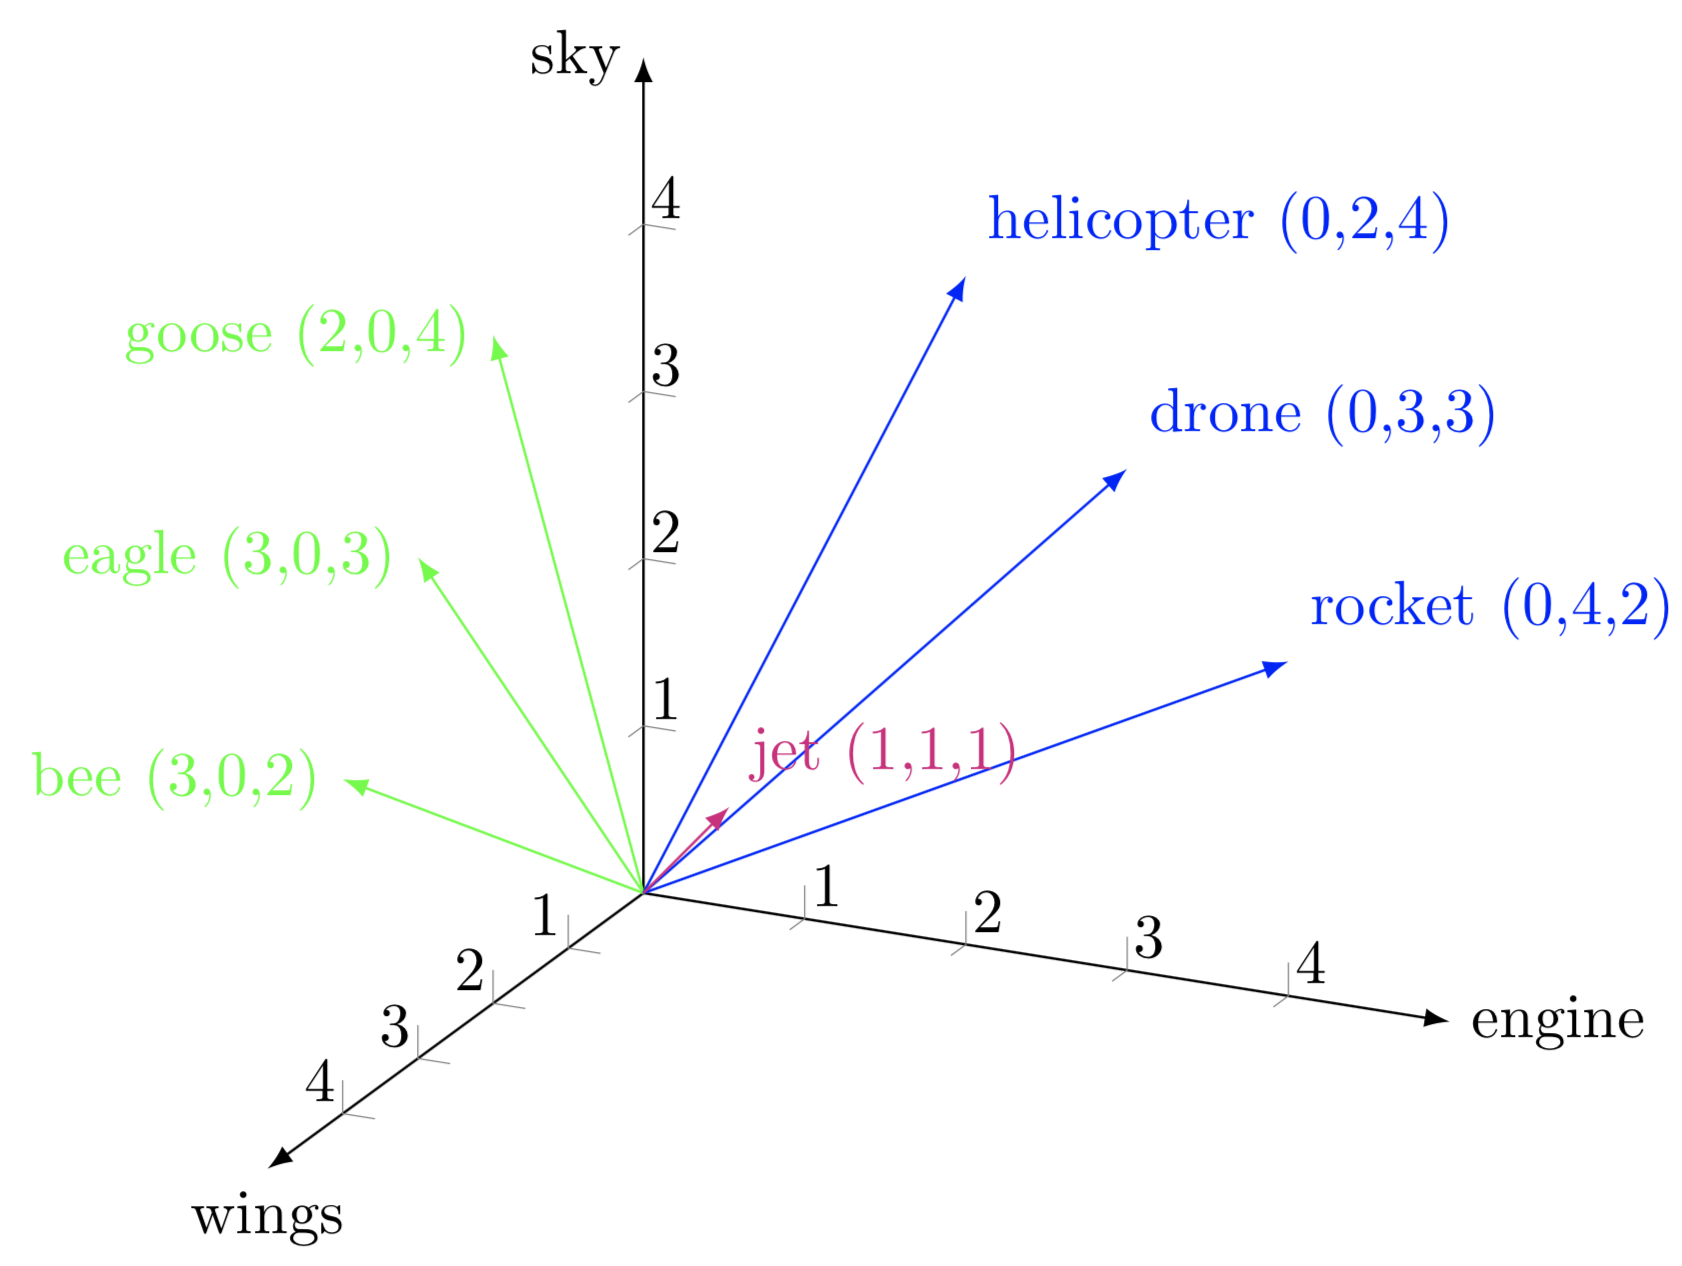
</div>

In [ ]:
# # Function to generate embeddings for a given text
# def generate_embedding(text, model="text-embedding-ada-002"):
#     openai.api_key = api_key
#     return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']

# # Function to process a single row and generate embeddings for both columns
# def process_row(row):
#     print(row)
#     return generate_embedding(row)

# # Create a DataFrame (you can load your own data using pd.read_csv or another method)
# df = pd.read_csv('aita.csv')

# # Extract the results and add them as new columns to the DataFrame
# df["title_embedding"] = df["title"].apply(process_row).apply(literal_eval)

# print("Finished title embeddings.")

# print("Done")

# What is clustering?

...

# How many clusters should we use?

<br>

We calculate the inertias of k-means models fit with different numbers of clusters to evaluate.

In [ ]:
# import pandas as pd
# from sklearn.cluster import KMeans

# inertias = []

# K = range(1, 100)

# for i in K:    
#     km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42).fit(X)
    
#     inertias.append(km.inertia_)

#####

# Calculate 1st, 2nd, 3rd derivs

# Plot 1st, 2nd, 3rd derivs

# Fit the model

In [ ]:
# Convert column to a numpy list

In [ ]:
# Initialize and fit model

# Visualize the model

<br>

Let's use principle component analysis to reduce the dimensionality of the embeddings further so we can plot them. 

In [ ]:
# Use PCA to reduce the embeddings to 3d dimensions

In [ ]:
%matplotlib widget

# Initialize plot

# Plot each sample category individually such that we can set label name

# Calculate and plot centroids for each cluster

# Prepare the dataset for GPT

In [ ]:
# Calculate distance to center of cluster for each sample

In [ ]:
# # Set your API key
# api_key = <key>
# openai.api_key = api_key

# reasons = []

# for k in range(0, 19):
#     posts = df.loc[df["cluster"] == k].sort_values(by="distance")["title"].values
        
#     question = f"I ran a clustering algorithm on embeddings of post titles on a subreddit called 'r/AmItheAsshole'. \
#         I'd like you to read through as many of these post titles as you can and sum up \
#         exactly ONE main reason why post submitters in this cluster are assholes. \
#         Please be as specific as possible, trying to avoid broad themes like selfishness and lack of empathy etc \
#         and instead opt for specific reasons like 'these people messed up weddings'. \
#         Avoid listing specific posts and commenting on the specific posts. \
#         As far as tone goes, please be as humorous and crass as possible. \
#         Here are the posts for cluster {k}: {posts[0:50]}"
    
#     try:
#         # Call the OpenAI API
#         response = openai.ChatCompletion.create(
#             model="gpt-3.5-turbo",
#             messages=[
#                 {"role": "user", "content": question},
#             ]
#         )
#     except Exception as e:
#         print(e)

#     # Extract and print the answer from the API response
#     answer = response.choices[0]["message"]["content"]
#     reasons.append(answer)

# What's next?

...